# 🧬 Fine-Tuning a Pre-trained Model on Genome Annotation Tracks Prediction

This notebook demonstrates a **simplified fine-tuning setup** that enables training of a **pre-trained Nucleotide Transformer v3 (NTv3) model** to predict genome annotation tracks directly from DNA sequences. The streamlined approach leverages a pre-trained NTv3 backbone as a feature extractor and adds a custom prediction head that outputs single-nucleotide resolution signal values for four annotation tracks from the NTv3 benchmark dataset (exon, intron, splice_acceptor & start_codon).

📊 We provide access to the NTv3-benchmark data that we released on our Hugging Face dataset: `InstaDeepAI/NTv3_benchmark_dataset`. In this repository, you will find ready-to-use genome FASTA files, genome annotation data, metadata, but also the splits that were used for the benchmark.

**🔧 Main Simplifications**: Compared to the full supervised tracks pipeline used in the paper, this notebook simplifies several aspects to enable faster experimentation with limited resources for users:
- **Constant learning rate**: Uses a fixed learning rate throughout training without learning rate scheduling
- **No gradient accumulation**: Implements simple step-based training without gradient accumulation, making the training loop more straightforward but changing the effective batch size compared with the full pipeline

**🎯 Notebook purpose:**
This notebook is configured to train the `NTv3_8M_pre` model on the `human` species from the NTv3 benchmark dataset. It is a lightweight, simplified setup that can be run on a T4 GPU on Colab.

## 💻 A note on hardware

While this pipeline is designed to run on limited resources (e.g., Google Colab with a T4 GPU and 2CPUs), the mentioned training time or displayed performances (see **Test evaluation** section) was obtained on a more powerful setup and is shown just as a reference. If you want to reach similar performance levels or the ones reported in the paper, you should be aware that you'll need **significant hardware resources** (high-end GPUs with substantial memory and multiple data loading workers). Training times will vary significantly based on your hardware configuration.

📝 Note for Google Colab users: This notebook is compatible with Colab and designed to work with limited resources! For faster training, make sure to enable GPU: Runtime → Change runtime type → GPU (T4 or better recommended).

# 0. 📦 Imports dependencies

In [ ]:
# Login to HuggingFace (required for gated models)
from huggingface_hub import login
login()

In [1]:
# Install dependencies
!pip install pyfaidx pyBigWig torchmetrics transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 38.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [torchmetrics] [torchmetrics]


In [2]:
import random
import functools
from typing import List, Dict, Callable
import os
from pathlib import Path
from huggingface_hub import HfApi, snapshot_download

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import AutoConfig, AutoModelForMaskedLM, AutoTokenizer
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pyfaidx import Fasta
from torchmetrics.classification import MulticlassMatthewsCorrCoef
from tqdm import tqdm

# 1. ⚙️ Configuration

## Configuration Parameters

### Model
- **`model_name`**: HuggingFace model name/identifier for the pretrained backbone model

### Data
- **`hf_repo_id`**: HuggingFace dataset repository ID containing the benchmark data
- **`species`**: Species name (e.g., "human") to select data from the benchmark dataset
- **`data_cache_dir`**: Directory where downloaded data files (FASTA, bigWig) will be stored
- **`sequence_length`**: Length of input sequences in base pairs (bp)
- **`keep_target_center_fraction`**: Fraction of center sequence to keep for target prediction (crops edges to focus on center)

### Training
- **`batch_size`**: Number of samples per batch
- **`learning_rate`**: Constant learning rate for optimizer
- **`weight_decay`**: L2 regularization coefficient for optimizer
- **`num_steps_training`**: Total number of training steps
- **`log_every_n_steps`**: Log training metrics every N steps

### Validation
- **`validate_every_n_steps`**: Run validation every N steps
- **`num_validation_samples`**: Number of samples to use for validation set

### Test
- **`num_test_samples`**: Number of samples to use for test set evaluation

### General
- **`seed`**: Random seed for reproducibility
- **`device`**: Device to run training on ("cuda" or "cpu")
- **`num_workers`**: Number of worker processes for DataLoader (0 = single-threaded)

In [3]:
config = {
    # Model
    "model_name": "InstaDeepAI/NTv3_8M_pre",
    
    # Data
    "hf_repo_id": "InstaDeepAI/NTv3_benchmark_dataset",
    "species_name": "human",
    "data_cache_dir": "./data",
    "sequence_length": 32_768,
    "keep_target_center_fraction": 0.375,
    
    # Training
    "batch_size": 4,
    "num_steps_training": 5000, 
    "log_every_n_steps": 40,
    "learning_rate": 1e-5,
    "weight_decay": 0.01,
    
    # Validation
    "validate_every_n_steps": 400, 
    "num_validation_samples": 1000,

    # Test
    "num_test_samples": 10000,
    
    # General
    "seed": 0,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "num_workers": 0, # NOTE: currently only supports num_workers=0
}

# Set random seed
torch.manual_seed(config["seed"])
np.random.seed(config["seed"])

# Set device
device = torch.device(config["device"])
print(f"Using device: {device}")

Using device: cuda


# 2. 📥 Genome & Tracks Data Download

Download the reference genome FASTA file and annotation tracks that are used to train the model.

In [4]:
def prepare_genomics_inputs(
    species: str,
    data_cache_dir: str | Path = "data",
    hf_repo_id: str = "InstaDeepAI/NTv3_benchmark_dataset",
) -> tuple[str, list[str], list[str], pd.DataFrame]:
    """
    Downloads:
      1) FASTA from HF dataset under: <species>/genome.fasta
      2) Bed files from HF dataset under: <species>/genome_annotation/**
      3) Splits from HF dataset under: <species>/splits.bed
      4) Metadata from HF dataset under: benchmark_metadata.tsv
    
    Args:
        species: Species name (e.g., "human", "arabidopsis")
        data_cache_dir: Directory where downloaded data files will be stored
        hf_repo_id: HuggingFace dataset repository ID
    
    Returns:
      (fasta_path, bed_path_list, bed_elements, splits_df)
    """
    cache = Path(data_cache_dir).expanduser().resolve()
    cache.mkdir(parents=True, exist_ok=True)
    
    # --- Download metadata + <species> files (FASTA, BigWigs, Splits) ---
    download_patterns = [f"{species}/genome.fasta", f"{species}/splits.bed"]
    
        # Download all BigWig files
    download_patterns.append(f"{species}/genome_annotation/*.bed")
    local_dir = Path(
        snapshot_download(
            repo_id=hf_repo_id,
            repo_type="dataset",
            allow_patterns=download_patterns,
            local_dir=str(cache),
        )
    )
    local_dir = Path("data/")
    
    # --- Organize outputs ---
    # FASTA file
    fasta_path_repo = f"{species}/genome.fasta"
    fasta_path = str(local_dir / fasta_path_repo)
    
    # Bed files - use downloaded files directly
    bed_dir = local_dir / species / "genome_annotation"

    # Find all downloaded BigWig files
    bed_paths = [str(bigwig_file) for bigwig_file in bed_dir.glob("*.bed")]
    bed_elements = [bigwig_file.stem for bigwig_file in bed_dir.glob("*.bed")]         
    
    # Splits file
    splits_path_repo = f"{species}/splits.bed"
    splits_path = local_dir / splits_path_repo

    splits_df = pd.read_csv(
        splits_path, 
        sep="\t", 
        header=None, 
        names=["chr_name", "start", "end", "split"],
        dtype={"chr_name": str, "start": int, "end": int, "split": str},
    )
    

    return fasta_path, bed_paths, bed_elements, splits_df

In [5]:
os.makedirs(config["data_cache_dir"], exist_ok=True)

# Download all species files + load the splits, and metadata
(
    fasta_path, 
    bed_paths, 
    bed_elements, 
    species_splits_df,
) = prepare_genomics_inputs(
    config["species_name"], 
    config["data_cache_dir"], 
    config["hf_repo_id"]
)

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

splits.bed:   0%|          | 0.00/9.95k [00:00<?, ?B/s]

human/genome.fasta:   0%|          | 0.00/3.27G [00:00<?, ?B/s]

human/genome_annotation/exon.bed:   0%|          | 0.00/13.0M [00:00<?, ?B/s]

human/genome_annotation/start_codon.bed:   0%|          | 0.00/1.18M [00:00<?, ?B/s]

human/genome_annotation/intron.bed:   0%|          | 0.00/10.6M [00:00<?, ?B/s]

human/genome_annotation/splice_acceptor.(…):   0%|          | 0.00/11.5M [00:00<?, ?B/s]

# 3. 🧠 Model and tokenizer setup
 
In this section, we set up the model and tokenizer. 
 
Our approach uses any suitable pretrained backbone from HuggingFace Transformers (for example, `InstaDeepAI/ntv3_650M_pre`),
which is then extended with an additional linear head. 
 
A classification head is added to the model to predict the presence or absence of each annotation track at each nucleotide.

In [6]:
def crop_center(x: np.ndarray, keep_target_center_fraction: float = 0.375) -> np.ndarray:
    """Crop the central sequence-length fraction for arrays of size (..., seq_len, num_tracks)"""
    seq_len = x.shape[-2]
    target_offset = int(seq_len * (1 - keep_target_center_fraction) // 2)
    target_length = seq_len - 2 * target_offset
    return x[..., target_offset:target_offset + target_length, :]


class ClassificationHead(nn.Module):
    """A linear head that predicts one scalar value per track."""
    def __init__(self, embed_dim: int, num_elements: int):
        super().__init__()
        self.num_elements = num_elements
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_elements*2)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.layer_norm(x)
        x = self.head(x)
        batch_size, sequence_length, _ = x.shape
        x = x.reshape(batch_size, sequence_length, self.num_elements, 2)
        return x


class HFModelForBedElements(nn.Module):
    """Simple model wrapper: HF backbone with species conditioning and bed element slicing"""
    
    def __init__(
        self,
        model_name: str,
        bed_elements: int,
        keep_target_center_fraction: float = 0.375,
    ):
        super().__init__()
        
        # Load config and model
        self.config = AutoConfig.from_pretrained(model_name, trust_remote_code=True)
        backbone = AutoModelForMaskedLM.from_pretrained(
            model_name, 
            trust_remote_code=True,
        )
        self.backbone = torch.compile(backbone)

        self.keep_target_center_fraction = keep_target_center_fraction
        
        # Annotation head (NTv3 outputs at single-nucleotide resolution)
        self.bed_head = ClassificationHead(self.config.embed_dim, len(bed_elements))
        self.model_name = model_name
    
    def forward(self, tokens: torch.Tensor, **kwargs) -> Dict[str, torch.Tensor]:
        # Forward through backbone
        outputs = self.backbone(input_ids=tokens, output_hidden_states=True)
        embedding = outputs.hidden_states[-1]  # Last hidden state
        
        # Crop to center fraction
        if self.keep_target_center_fraction < 1.0:
            embedding = crop_center(embedding, self.keep_target_center_fraction)
        
        # Predict bigwig tracks
        bed_logits = self.bed_head(embedding)
        
        return {"bed_tracks_logits": bed_logits}

In [7]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(config["model_name"], trust_remote_code=True)

# Create model
model = HFModelForBedElements(
    model_name=config["model_name"],
    bed_elements=bed_elements,
    keep_target_center_fraction=config["keep_target_center_fraction"],
)
model = model.to(device)
model.train()

print(f"Model loaded: {config['model_name']}")
print(f"Number of bed tracks: {len(bed_elements)}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

tokenizer_config.json:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

tokenization_ntv3.py:   0%|          | 0.00/7.85k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/ntv3_base_model:
- tokenization_ntv3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


vocab.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/149 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.75k [00:00<?, ?B/s]

configuration_ntv3_pretrained.py:   0%|          | 0.00/8.09k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/ntv3_base_model:
- configuration_ntv3_pretrained.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_ntv3_pretrained.py:   0%|          | 0.00/35.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/ntv3_base_model:
- modeling_ntv3_pretrained.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
2025-12-23 20:33:33.557990: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-23 20:33:33.572650: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766518413.586864     753 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766518413.591550   

model.safetensors:   0%|          | 0.00/30.8M [00:00<?, ?B/s]

Model loaded: InstaDeepAI/NTv3_8M_pre
Number of bed tracks: 4
Model parameters: 7,695,043


# 4. 🔄 Data loading

Create PyTorch datasets and data loaders that efficiently sample random genomic windows from the reference genome and extract corresponding BigWig signal values. The dataset handles sequence tokenization, target scaling, and chromosome-based train/val/test splits.

In [8]:
# Process-local cache for file handles (one per worker process)
# This allows safe multi-worker DataLoader usage
_fasta_cache = {}  # Maps (process_id, file_path) -> Fasta handle
_bed_cache = {}  # Maps (process_id, file_path) -> pyBigWig handle


def _get_fasta_handle(fasta_path: str) -> Fasta:
    """Get or create a FASTA file handle for the current process."""
    process_id = os.getpid()
    abs_path = str(Path(fasta_path).resolve())
    cache_key = (process_id, abs_path)
    
    if cache_key not in _fasta_cache:
        _fasta_cache[cache_key] = Fasta(abs_path, as_raw=True, sequence_always_upper=True)
    
    return _fasta_cache[cache_key]

def _get_bed_handle(bed_path: str) -> pd.DataFrame:
    """Get or create a Bed file handle for the current process."""
    process_id = os.getpid()
    abs_path = str(Path(bed_path).resolve())
    cache_key = (process_id, abs_path)
    
    if cache_key not in _bed_cache:
        # Check if file exists before trying to open
        if not Path(abs_path).exists():
            raise FileNotFoundError(f"Bed file not found: {abs_path}")
        
        try:
            _bed_cache[cache_key] = pd.read_csv(abs_path, sep="\t", header=None)
            _bed_cache[cache_key].columns = ["chr", "start", "end", "", "", "strand", "element"]
        except Exception as e:
            raise RuntimeError(f"Failed to open Bed file: {abs_path} with error: {str(e)}") from e
    
    return _bed_cache[cache_key]



class GenomeBedDataset(Dataset):
    """
    A PyTorch dataset to access a reference genome and bigwig tracks. The dataset is 
    compatible with multi-worker DataLoaders (using process-local file handles and lazy 
    loading). For each sample, a random genomic region is picked from the specified split,
    and a random window of length `sequence_length` within that region is returned.
    """

    def __init__(
        self,
        fasta_path: str,
        bed_path_list: list[str],
        chrom_regions: pd.DataFrame,
        split: str,
        sequence_length: int,
        num_samples: int,
        tokenizer: AutoTokenizer,
        keep_target_center_fraction: float = 1.0,
    ):
        super().__init__()

        # Store paths instead of opening files immediately (for multi-worker compatibility)
        self.fasta_path = fasta_path
        self.bed_path_list = bed_path_list
        self.sequence_length = sequence_length
        self.num_samples = num_samples
        self.tokenizer = tokenizer
        self.keep_target_center_fraction = keep_target_center_fraction
        self.chrom_regions = chrom_regions

        # Filter regions by split
        split_regions = self.chrom_regions[self.chrom_regions["split"] == split].copy()

        # Filter valid regions (must be large enough for sequence_length)
        self.valid_regions = [
            (r.chr_name, r.start, r.end) 
            for r in split_regions.itertuples() 
            if r.end - r.start >= self.sequence_length
        ]

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Sample a random region from the valid regions
        chrom, region_start, region_end = random.choice(self.valid_regions)
        
        # Sample a random window within this region
        max_start = region_end - self.sequence_length
        start = random.randint(region_start, max_start)
        end = start + self.sequence_length

        # Sequence - get FASTA handle lazily (cached per worker process)
        fasta = _get_fasta_handle(self.fasta_path)
        seq = fasta[chrom][start:end]  # string slice
        # Tokenize with padding and truncation to ensure consistent lengths for batching
        tokenized = self.tokenizer(
            seq,
            padding="max_length",
            truncation=True,
            max_length=self.sequence_length,
            return_tensors="pt",
        )
        tokens = tokenized["input_ids"][0]  # Shape: (max_length,)

        # Get bed targets
        bed_sequence_length = self.sequence_length * self.keep_target_center_fraction
        bed_start = int(start + (self.sequence_length - bed_sequence_length) // 2)
        bed_end = int(bed_start + bed_sequence_length)
        bed_targets = np.zeros((int(bed_sequence_length), len(self.bed_path_list)), dtype=np.int32)
        for bed_idx, bed_path in enumerate(self.bed_path_list):
            bed_df = _get_bed_handle(bed_path)
            regions = bed_df[(bed_df["chr"] == chrom) & (bed_df["start"] >= bed_start) & (bed_df["end"] <= bed_end)]
            for _, row in regions.iterrows():
                bed_targets[row["start"] - bed_start:row["end"] - bed_start, bed_idx] = 1

        # pyBigWig returns NaN where no data; turn NaN into 0
        bed_targets = torch.tensor(bed_targets, dtype=torch.int64)

        sample = {
            "tokens": tokens,
            "bed_targets": bed_targets,
            "chrom": chrom,
            "start": start,
            "end": end,
        }
        return sample

In [9]:
# Create datasets & dataloaders
create_dataset_fn = functools.partial(
    GenomeBedDataset,
    fasta_path=fasta_path,
    bed_path_list=bed_paths,
    chrom_regions=species_splits_df,
    sequence_length=config["sequence_length"],
    tokenizer=tokenizer,
    keep_target_center_fraction=config["keep_target_center_fraction"],
)

train_dataset = create_dataset_fn(
    split="train",
    num_samples=config["num_steps_training"] * config["batch_size"],
)

val_dataset = create_dataset_fn(
    split="val",
    num_samples=config["num_validation_samples"],
)

test_dataset = create_dataset_fn(
    split="test",
    num_samples=config["num_test_samples"],
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config["batch_size"],
    shuffle=True,
    num_workers=config["num_workers"],
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config["batch_size"],
    shuffle=False,
    num_workers=config["num_workers"],
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config["batch_size"],
    shuffle=False,
    num_workers=config["num_workers"],
)

print(f"\nTrain samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Train samples: 20000
Val samples: 1000
Test samples: 10000


# 5. ⚙️ Optimizer setup

Configure the AdamW optimizer with learning rate and weight decay hyperparameters. This optimizer will update the model parameters during training to minimize the loss function.



In [10]:
# Training setup
print(f"Training configuration:")
print(f"  Batch size: {config['batch_size']}")
print(f"  Total training steps: {config['num_steps_training']}")
print(f"  Log metrics every: {config['log_every_n_steps']} steps")
print(f"  Validate every: {config['validate_every_n_steps']} steps")

# Setup optimizer
optimizer = AdamW(
    model.parameters(),
    lr=config["learning_rate"],
    weight_decay=config["weight_decay"],
)

print(f"\nOptimizer setup:")
print(f"  Learning rate: {config['learning_rate']}")

Training configuration:
  Batch size: 4
  Total training steps: 5000
  Log metrics every: 40 steps
  Validate every: 400 steps

Optimizer setup:
  Learning rate: 1e-05


# 6. 📊 Metrics setup

Set up evaluation metrics to track model performance during training and validation. We use Matthews Correlation Coefficient (MCC) to measure how well the predicted annotation tracks match the ground truth signals.

In [11]:

class TracksMetrics:
    """Metrics to handle multi-track MCC correlations and losses"""
    
    def __init__(self, track_names: List[str], split: str):
        self.track_names = track_names
        self.num_tracks = len(track_names)
        self.split = split

        # Initialise metrics 
        self.mccs = [
            MulticlassMatthewsCorrCoef(num_classes=2).to(device)    
            for _ in range(len(track_names))
        ]
        self.losses = []

        # Record mean metrics per logging interval
        self.step_idxs = []
        self.mean_mcc = []
        self.mean_losses = []
    
    def reset(self):
        for mcc in self.mccs:
            mcc.reset()
        self.losses = []
    
    def update(
        self, 
        logits: torch.Tensor, 
        labels: torch.Tensor,
        loss: float
    ):
        """
        Update the metrics with logits and labels of shape (..., num_tracks) and a scalar loss.
        """
        # Flatten batch and sequence dimensions
        pred_flat = logits.detach().reshape(-1, self.num_tracks, 2)  # (N, num_tracks)
        target_flat = labels.detach().reshape(-1, self.num_tracks)  # (N, num_tracks)
        
        # Update metrics
        for i, mcc in enumerate(self.mccs):
            mcc.update(pred_flat[:, i, :], target_flat[:, i])
        self.losses.append(loss)
    
    def compute(self) -> Dict[str, float]:
        """Compute the MCC correlations and loss and return a dictionary of metrics."""
        # Per-track MCC correlations
        metrics_dict = {}
        for i, mcc in enumerate(self.mccs):
            metrics_dict[f"{self.track_names[i]}/mcc"] = mcc.compute().cpu().item()
        metrics_dict["mean/mcc"] = np.mean(list(metrics_dict.values()))
        
        # Mean loss
        metrics_dict["loss"] = np.mean(self.losses)
        
        return metrics_dict

    def update_mean_metrics(self, step_idx: int):
        """Update the mean metrics over the logging interval and save to a csv file."""
        # Update mean metrics with the mean mcc & average loss
        metrics_dict = self.compute()
        self.step_idxs.append(step_idx)
        self.mean_mcc.append(metrics_dict["mean/mcc"])
        self.mean_losses.append(metrics_dict["loss"])

        # Save metrics to a csv for plotting
        data = {
            "step": self.step_idxs,
            "mean_loss": self.mean_losses,
            "mean_mcc": self.mean_mcc,
        }
        df = pd.DataFrame(data)
        df.to_csv(f"metrics_{self.split}.csv", index=False)
        
    def print_metrics(self, print_per_track: bool = False):
        """Print a summary of the metrics."""
        print(
            f"Step {self.step_idxs[-1]}/{config['num_steps_training']} | "
            f"Loss: {self.mean_losses[-1]:.4f} | "
            f"Mean MCC: {self.mean_mcc[-1]:.4f}"
        )
        metrics_dict = self.compute()
        if print_per_track:
            for metric_key, metric_value in metrics_dict.items():
                print(f"    {metric_key}: {metric_value:.4f}")
    

In [12]:
train_metrics = TracksMetrics(bed_elements, "train")
val_metrics = TracksMetrics(bed_elements, "val")
test_metrics = TracksMetrics(bed_elements, "test")

# 7. 📉 Loss functions

Use the focal loss to focus the model on learning the difficult to classify examples.

In [13]:

def focal_loss(
    logits: torch.Tensor,
    targets: torch.Tensor,
    gamma: float = 2.0,
    epsilon: float = 1e-7,
) -> torch.Tensor:
    """
    Computes focal loss for nucleotide-level classification tasks from logits.
    It handles masking of invalid positions. Includes optional class weights.

    """
    # Compute probabilities
    log_probs = F.log_softmax(logits, dim=-1)
    probabilities = torch.exp(log_probs)

    # Reshape for loss computation
    # num_classes: scalar
    num_classes = probabilities.shape[-1]
    probabilities = torch.reshape(probabilities, (-1, num_classes))
    log_probs = torch.reshape(log_probs, (-1, num_classes))
    targets = torch.reshape(targets, (-1,))


    # Compute focal loss per position
    loss = -torch.sum(
        torch.gather(
            (1 - probabilities) ** gamma * log_probs,
            dim=-1,
            index=targets[..., None],
        ),
        dim=-1,
    )  # shape: (total_positions,)

    # Average loss over valid positions only
    loss = loss.sum() / (loss.numel() + epsilon)  # type: ignore

    return loss


# 8. 🏃 Training loop

Run the main training loop that iterates through batches, computes gradients, and updates model parameters. The loop includes periodic validation checks and real-time metric visualization to monitor training progress.

In [14]:
def train_step(
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    batch: Dict[str, torch.Tensor],
    train_metrics: TracksMetrics,
) -> None:
    """Single training step."""
    tokens = batch["tokens"].to(device)
    bed_targets = batch["bed_targets"].to(device)
    
    # Forward pass
    outputs = model(tokens=tokens)
    bed_logits = outputs["bed_tracks_logits"]
    
    # Compute loss
    loss = focal_loss(
        logits=bed_logits,
        targets=bed_targets,
    )

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Update metrics
    train_metrics.update(
        logits=bed_logits,
        labels=bed_targets,
        loss=loss.item()
    )
    


def validation_step(
    model: nn.Module,
    batch: Dict[str, torch.Tensor],
    metrics: TracksMetrics,
) -> None:
    """Single validation step."""
    tokens = batch["tokens"].to(device)
    bed_targets = batch["bed_targets"].to(device)
    
    with torch.no_grad():
        # Forward pass
        outputs = model(tokens=tokens)
        bed_logits = outputs["bed_tracks_logits"]
        
        # Compute loss
        loss = focal_loss(
            logits=bed_logits,
            targets=bed_targets,
        )
        
        # Update metrics
        metrics.update(
            logits=bed_logits,
            labels=bed_targets,
            loss=loss.item()
        )

## Run Training Loop

In [15]:
# Training loop
print(f"Starting training for {config['num_steps_training']} steps\n")

# Create iterator for training data (will cycle if needed)
train_iter = iter(train_loader)
model.train()

# Main training loop
for step_idx in range(config["num_steps_training"]):
    try:
        batch = next(train_iter)
    except StopIteration:
        # Restart iterator if we run out of data
        train_iter = iter(train_loader)
        batch = next(train_iter)
    
    # Take a training step
    train_step(model, optimizer, batch, train_metrics)

    # Logging
    if (step_idx + 1) % config["log_every_n_steps"] == 0:
        train_metrics.update_mean_metrics(step_idx + 1)
        train_metrics.print_metrics()
        train_metrics.reset()
    
    # Validation
    if (step_idx + 1) % config["validate_every_n_steps"] == 0:
        print(f"\nRunning validation at step {step_idx + 1}...")
        model.eval()
        
        for val_batch in val_loader:
            validation_step(model, val_batch, val_metrics)
        
        val_metrics.update_mean_metrics(step_idx + 1)
        val_metrics.print_metrics(print_per_track=True)
        val_metrics.reset()

        # Back to training mode
        print("\n" + "-"*100 + "\nTraining metrics:")
        model.train()  

print(f"\nTraining completed after {config['num_steps_training']} steps.")


Starting training for 5000 steps



/app/.venv/lib/python3.11/site-packages/torch/_inductor/compile_fx.py:167: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


Step 40/5000 | Loss: 0.2218 | Mean MCC: 0.0032
Step 80/5000 | Loss: 0.0547 | Mean MCC: 0.0031
Step 120/5000 | Loss: 0.0405 | Mean MCC: 0.0065
Step 160/5000 | Loss: 0.0391 | Mean MCC: 0.0111
Step 200/5000 | Loss: 0.0391 | Mean MCC: 0.0098
Step 240/5000 | Loss: 0.0381 | Mean MCC: 0.0492
Step 280/5000 | Loss: 0.0342 | Mean MCC: 0.0149
Step 320/5000 | Loss: 0.0357 | Mean MCC: 0.0468
Step 360/5000 | Loss: 0.0396 | Mean MCC: 0.0194
Step 400/5000 | Loss: 0.0388 | Mean MCC: 0.0353

Running validation at step 400...
Step 400/5000 | Loss: 0.0369 | Mean MCC: 0.0381
    start_codon/mcc: 0.0506
    exon/mcc: 0.0876
    intron/mcc: 0.0146
    splice_acceptor/mcc: -0.0003
    mean/mcc: 0.0381
    loss: 0.0369

----------------------------------------------------------------------------------------------------
Training metrics:
Step 440/5000 | Loss: 0.0315 | Mean MCC: 0.0215
Step 480/5000 | Loss: 0.0388 | Mean MCC: 0.0094
Step 520/5000 | Loss: 0.0336 | Mean MCC: 0.0464
Step 560/5000 | Loss: 0.0348 | M

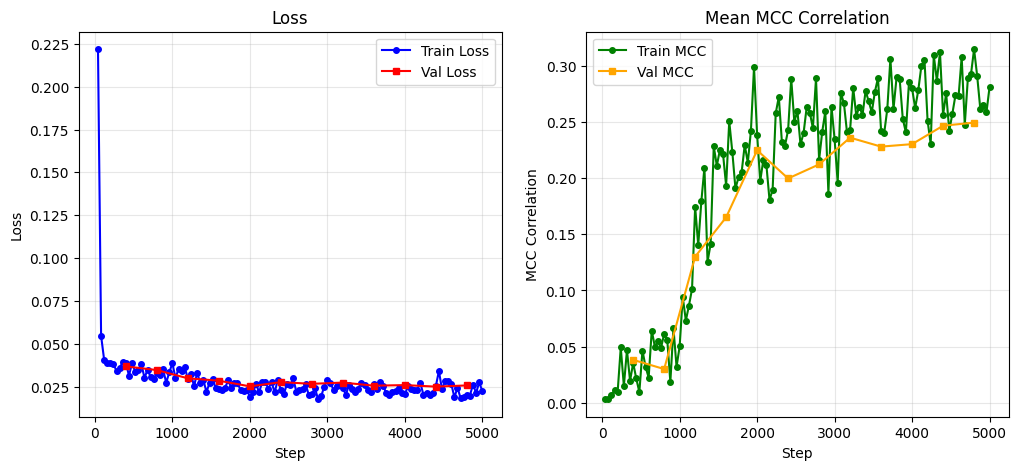

In [16]:
# Plot training results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

df_train = pd.read_csv("metrics_train.csv")
df_val = pd.read_csv("metrics_val.csv")

# Plot Loss
axes[0].plot(df_train["step"], df_train["mean_loss"], 'b-o', label='Train Loss', markersize=4, linewidth=1.5)
axes[0].plot(df_val["step"], df_val["mean_loss"], 'r-s', label='Val Loss', markersize=4, linewidth=1.5)
axes[0].set_xlabel('Step')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot MCC Correlation
axes[1].plot(df_train["step"], df_train["mean_mcc"], 'g-o', label='Train MCC', markersize=4, linewidth=1.5)
axes[1].plot(df_val["step"], df_val["mean_mcc"], 'orange', marker='s', label='Val MCC', markersize=4, linewidth=1.5)
axes[1].set_xlabel('Step')
axes[1].set_ylabel('MCC Correlation')
axes[1].set_title('Mean MCC Correlation')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 9. 🧪 Test evaluation

Evaluate the fine-tuned model on the held-out test set to assess final performance. This provides an unbiased estimate of how well the model generalizes to unseen genomic regions.

In [17]:
# Calculate number of test steps (based on deepspeed pipeline)
num_test_samples = len(test_dataset)
num_test_steps = num_test_samples // config["batch_size"]
print(f"Running test evaluation with {num_test_steps} steps ({num_test_samples} samples)")

# Set model to eval mode
model.eval()

# Run test evaluation with progress bar
for test_batch in tqdm(test_loader, desc="Test evaluation", total=num_test_steps):        
    validation_step(        
        model, 
        test_batch, 
        test_metrics,
    )
    
# Compute final test metrics
test_metrics_dict = test_metrics.compute()
print("\n" + "="*50)
print("Test Set Results")
print("="*50)
print(f"\nMetrics:")
print(f"  Mean MCC: {test_metrics_dict['mean/mcc']:.4f}")
for track_name in bed_elements:    
    print(f"    {track_name}/mcc: {test_metrics_dict[f'{track_name}/mcc']:.4f}")

Running test evaluation with 2500 steps (10000 samples)


Test evaluation: 100%|██████████| 2500/2500 [13:34<00:00,  3.07it/s]


Test Set Results

Metrics:
  Mean MCC: 0.2215
    start_codon/mcc: 0.0177
    exon/mcc: 0.4044
    intron/mcc: 0.4597
    splice_acceptor/mcc: 0.0044


 ## Test set results

Mean MCC: 0.2215

- start_codon/mcc: 0.0177
- exon/mcc: 0.4044
- intron/mcc: 0.4597
- splice_acceptor/mcc: 0.0044